# Projet IA : voyageur de commerce
Marie Magny
Mickael Nabet
Maxime Boyer

### A*

Dans un etat, il faut indiquer la ville actuelle ainsi que les autres villes où on est déjà passé
Il faut indiquer tous ces trucs (définir l'etat, les actions possibles, les résultats d'une action dans un état, quel est la condition de fin) pour avoir une bonne note

Spanning tree = heuristique avec sommets restants + sommet actuel + sommet départ

=> but est de choisir la bonne ville pour après dans A*

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

In [6]:
def generate_graph(nbr_sommets=5, max_poids=10):
    graphe = nx.complete_graph(nbr_sommets)
    nx.set_edge_attributes(graphe, {e: {'weight': randint(1, max_poids)} for e in graphe.edges})
    return graphe

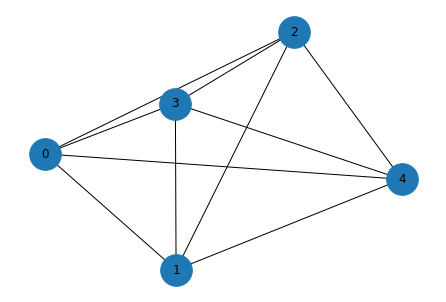

In [7]:
#visualisation
graphe = generate_graph()
nx.draw(graphe, with_labels=True, node_size=1000)
plt.show()

In [8]:
for t in graphe.edges(data=True):
    print(t)

(0, 1, {'weight': 10})
(0, 2, {'weight': 8})
(0, 3, {'weight': 9})
(0, 4, {'weight': 2})
(1, 2, {'weight': 1})
(1, 3, {'weight': 8})
(1, 4, {'weight': 6})
(2, 3, {'weight': 10})
(2, 4, {'weight': 8})
(3, 4, {'weight': 5})


In [9]:
from algorithmx.networkx import add_graph
from algorithmx import jupyter_canvas

canvas = jupyter_canvas()
add_graph(canvas, graphe)

JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}}}}', '{"attrs": {"edge…

https://algrx.github.io/docs/python/examples/networkx-tutorial.html